In [1]:
import numpy as np
from glasflow import CouplingNSF
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from hierarchical_flow_tools import FlowLikelihood
from nessai.flowsampler import FlowSampler
from nessai.utils import setup_logger
from nessai.plot import corner_plot
from nessai.model import Model
from hierarchical_flow_tools.models import NessaiModel
torch.manual_seed(1729)
np.random.seed(1729)

glasflow is using its own internal version of nflows


# Worked example of hierarchical inference with normalising flows

We wish to infer population parameters $\lambda$ from a set of $N$ gravitational wave observations $\{d\}$. For each set of data $d_i$, we obtain posterior samples $\{\theta_i\}$. Ignoring selection effects, the population posterior is
$$
p(\lambda | \{\theta\}) = \prod _ {i = 0} ^ N \frac{1}{S_i} \sum _ {j = 0} ^ {S_i} \frac{\mathcal{L}(\theta_i | \lambda )}{\pi(\theta_i)}.
$$

Let's train a normalising flow to learn the distribution $\mathcal{L}(\theta_i | \lambda )$.

For a candidate example, we're going to replace everything with Gaussians. Our population is a multivariate, uncorrelated Gaussian with mean $\mu$ and a diagonal covariance matrix with sigmas $\{\sigma_1,...,\sigma_5\}$. Each event is a Gaussian with 0.1 variance and a mean drawn from this population Gaussian.



### Training the flow

We train the flow over some boundary of means and variances. We'll say the means are all within [-5, 5] and the variances between [0.5, 2.5]. For each population Gaussian, we draw one posterior sample for one event.

In [2]:
# construct the training and validation data
train_means = np.random.uniform(-5, 5, size=(int(1e6), 5))
train_variances = np.random.uniform(0.5, 2.5, size=(int(1e6), 5))

x_train = np.array([np.random.multivariate_normal(m, np.eye(5)*v) for m,v in zip(train_means, train_variances)])
y_train = np.concatenate([train_means, train_variances], axis=1)

x_scaler = np.vstack([np.mean(x_train,axis=0), np.std(x_train,axis=0)])
y_scaler = np.vstack([np.mean(y_train,axis=0),np.std(y_train,axis=0)])

x_train = (x_train - x_scaler[0]) / x_scaler[1]
y_train = (y_train - y_scaler[0]) / y_scaler[1]

test_means = np.random.uniform(-5, 5, size=(int(1e4), 5))
test_variances = np.random.uniform(0.5, 2.5, size=(int(1e4), 5))

x_val = np.array([np.random.multivariate_normal(m, np.eye(5)*v) for m,v in zip(test_means, test_variances)])
y_val = np.concatenate([test_means, test_variances], axis=1)

x_val = (x_val - x_scaler[0]) / x_scaler[1]
y_val = (y_val - y_scaler[0]) / y_scaler[1]


In [3]:
batch_size = int(1e5)
device = "cuda:0"
flow = CouplingNSF(
    n_inputs=5,
    n_transforms=4,
    n_conditional_inputs=10,
    n_neurons=32,
    batch_norm_between_transforms=True,
)
flow.to(device)
print(f"Created flow and sent to {device}")
optimiser = torch.optim.Adam(flow.parameters())

Created flow and sent to cuda:0


In [4]:
x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
y_train_tensor = torch.from_numpy(y_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

x_val_tensor = torch.from_numpy(x_val.astype(np.float32))
y_val_tensor = torch.from_numpy(y_val.astype(np.float32))
val_dataset = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

We train the flow for 50 epochs - this process could be optimised further, but this works sufficiently well for this example.

In [5]:
epochs = 50
loss = dict(train=[], val=[])

for i in range(epochs):
    flow.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimiser.zero_grad()
        _loss = -flow.log_prob(x, conditional=y).mean()
        _loss.backward()
        optimiser.step()
        train_loss += _loss.item()
    loss["train"].append(train_loss / len(train_loader))

    flow.eval()
    val_loss = 0.0
    for batch in val_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            _loss = -flow.log_prob(x, conditional=y).mean().item()
        val_loss += _loss
    loss["val"].append(val_loss / len(val_loader))
    if not i % 10:
        print(
            f"Epoch {i} - train: {loss['train'][-1]:.3f}, val: {loss['val'][-1]:.3f}"
        )

flow.eval()
print("Finished training")

Epoch 0 - train: 6.756, val: 12.850
Epoch 10 - train: 2.256, val: 2.251
Epoch 20 - train: 2.205, val: 2.209
Epoch 30 - train: 2.194, val: 2.200
Epoch 40 - train: 2.189, val: 2.197
Finished training


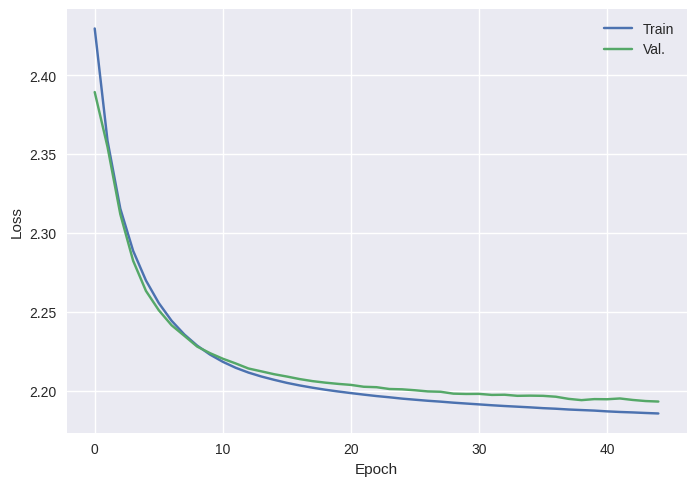

In [6]:
with plt.style.context("seaborn"):
    plt.plot(loss["train"][5:], label="Train")
    plt.plot(loss["val"][5:], label="Val.")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Hierarchical inference

With our trained flow in hand, we're ready to do some hierarchical inference. We'll use the `nessai` nested sampler to infer our 10 hyperparameters, using the flow as a proxy for the likelihood as described earlier.

Our "data" will consist of 10 events with 1000 posterior samples each, where each event mean has been drawn from the population and the variance is 0.05. For ease, we'll just use the first events of our validation set. Feel free to change these numbers and examine the resulting change in the parameter estimation performance!

In [7]:
event_mean = test_means[0]
event_variance = test_variances[0]
noise_variance = 0.05
event_samples = np.array(
    [np.random.multivariate_normal(
        np.random.multivariate_normal(
            np.random.multivariate_normal(event_mean, np.eye(5)*event_variance), # determine the location of the event's true parameters
            np.eye(5)*noise_variance), # scatter the observed maximum likelihood location from the truth according to the posterior width
        np.eye(5)*noise_variance,size=1000) # draw 1000 "posterior samples" from this perturbed distribution
    for i in range(10)] # do this for all 10 events
)

event_samples_rescaled = (event_samples - x_scaler[0])/x_scaler[1]  # rescale these samples prior to inference

In [8]:
# setup for nessai parameter estimation: we need to name the parameters and provide some prior bounds.
names = [f"mu_{x}" for x in range(1,6)] + [f"sigma_{x}" for x in range(1,6)]
bounds = dict()
for k, n in enumerate(names):
    bounds[n] = [-5, 5] if k < 5 else [0.5,2.5]

In [38]:
torch_yscaler = torch.as_tensor(y_scaler, device=device).float()
flike = FlowLikelihood(
    flow, device, 
    data=torch.as_tensor(event_samples_rescaled, device=device).float(),
    batch_size=100,
    conditional_rescaling_function=lambda x: (x - torch_yscaler[0]) / torch_yscaler[1])
    
model_fast = NessaiModel(names, bounds, flow_likelihood=flike)
output_fast = './outdir_norm_fast'
setup_logger(output=output_fast, log_level='CRITICAL')
fs_fast = FlowSampler(model_fast, output=output_fast, resume=False, seed=1729, nlive=5000)
fs_fast.run()

Drawing live points: 100%|██████████| 5000/5000 [00:07<00:00, 629.89it/s]
01-30 17:01 nessai.samplers.nestedsampler CRITICAL: Starting nested sampling loop
01-30 17:11 nessai.samplers.base CRITICAL: Checkpointing nested sampling
01-30 17:12 nessai.samplers.nestedsampler CRITICAL: Final evidence: -37.947 +/- 0.046
01-30 17:12 nessai.samplers.nestedsampler CRITICAL: Information: 10.63
01-30 17:12 nessai.samplers.nestedsampler CRITICAL: Final p-value for the insertion indices is less than 0.05, this could be an indication of problems during sampling. Consider checking the diagnostic plots.
01-30 17:12 nessai.samplers.base CRITICAL: Checkpointing nested sampling


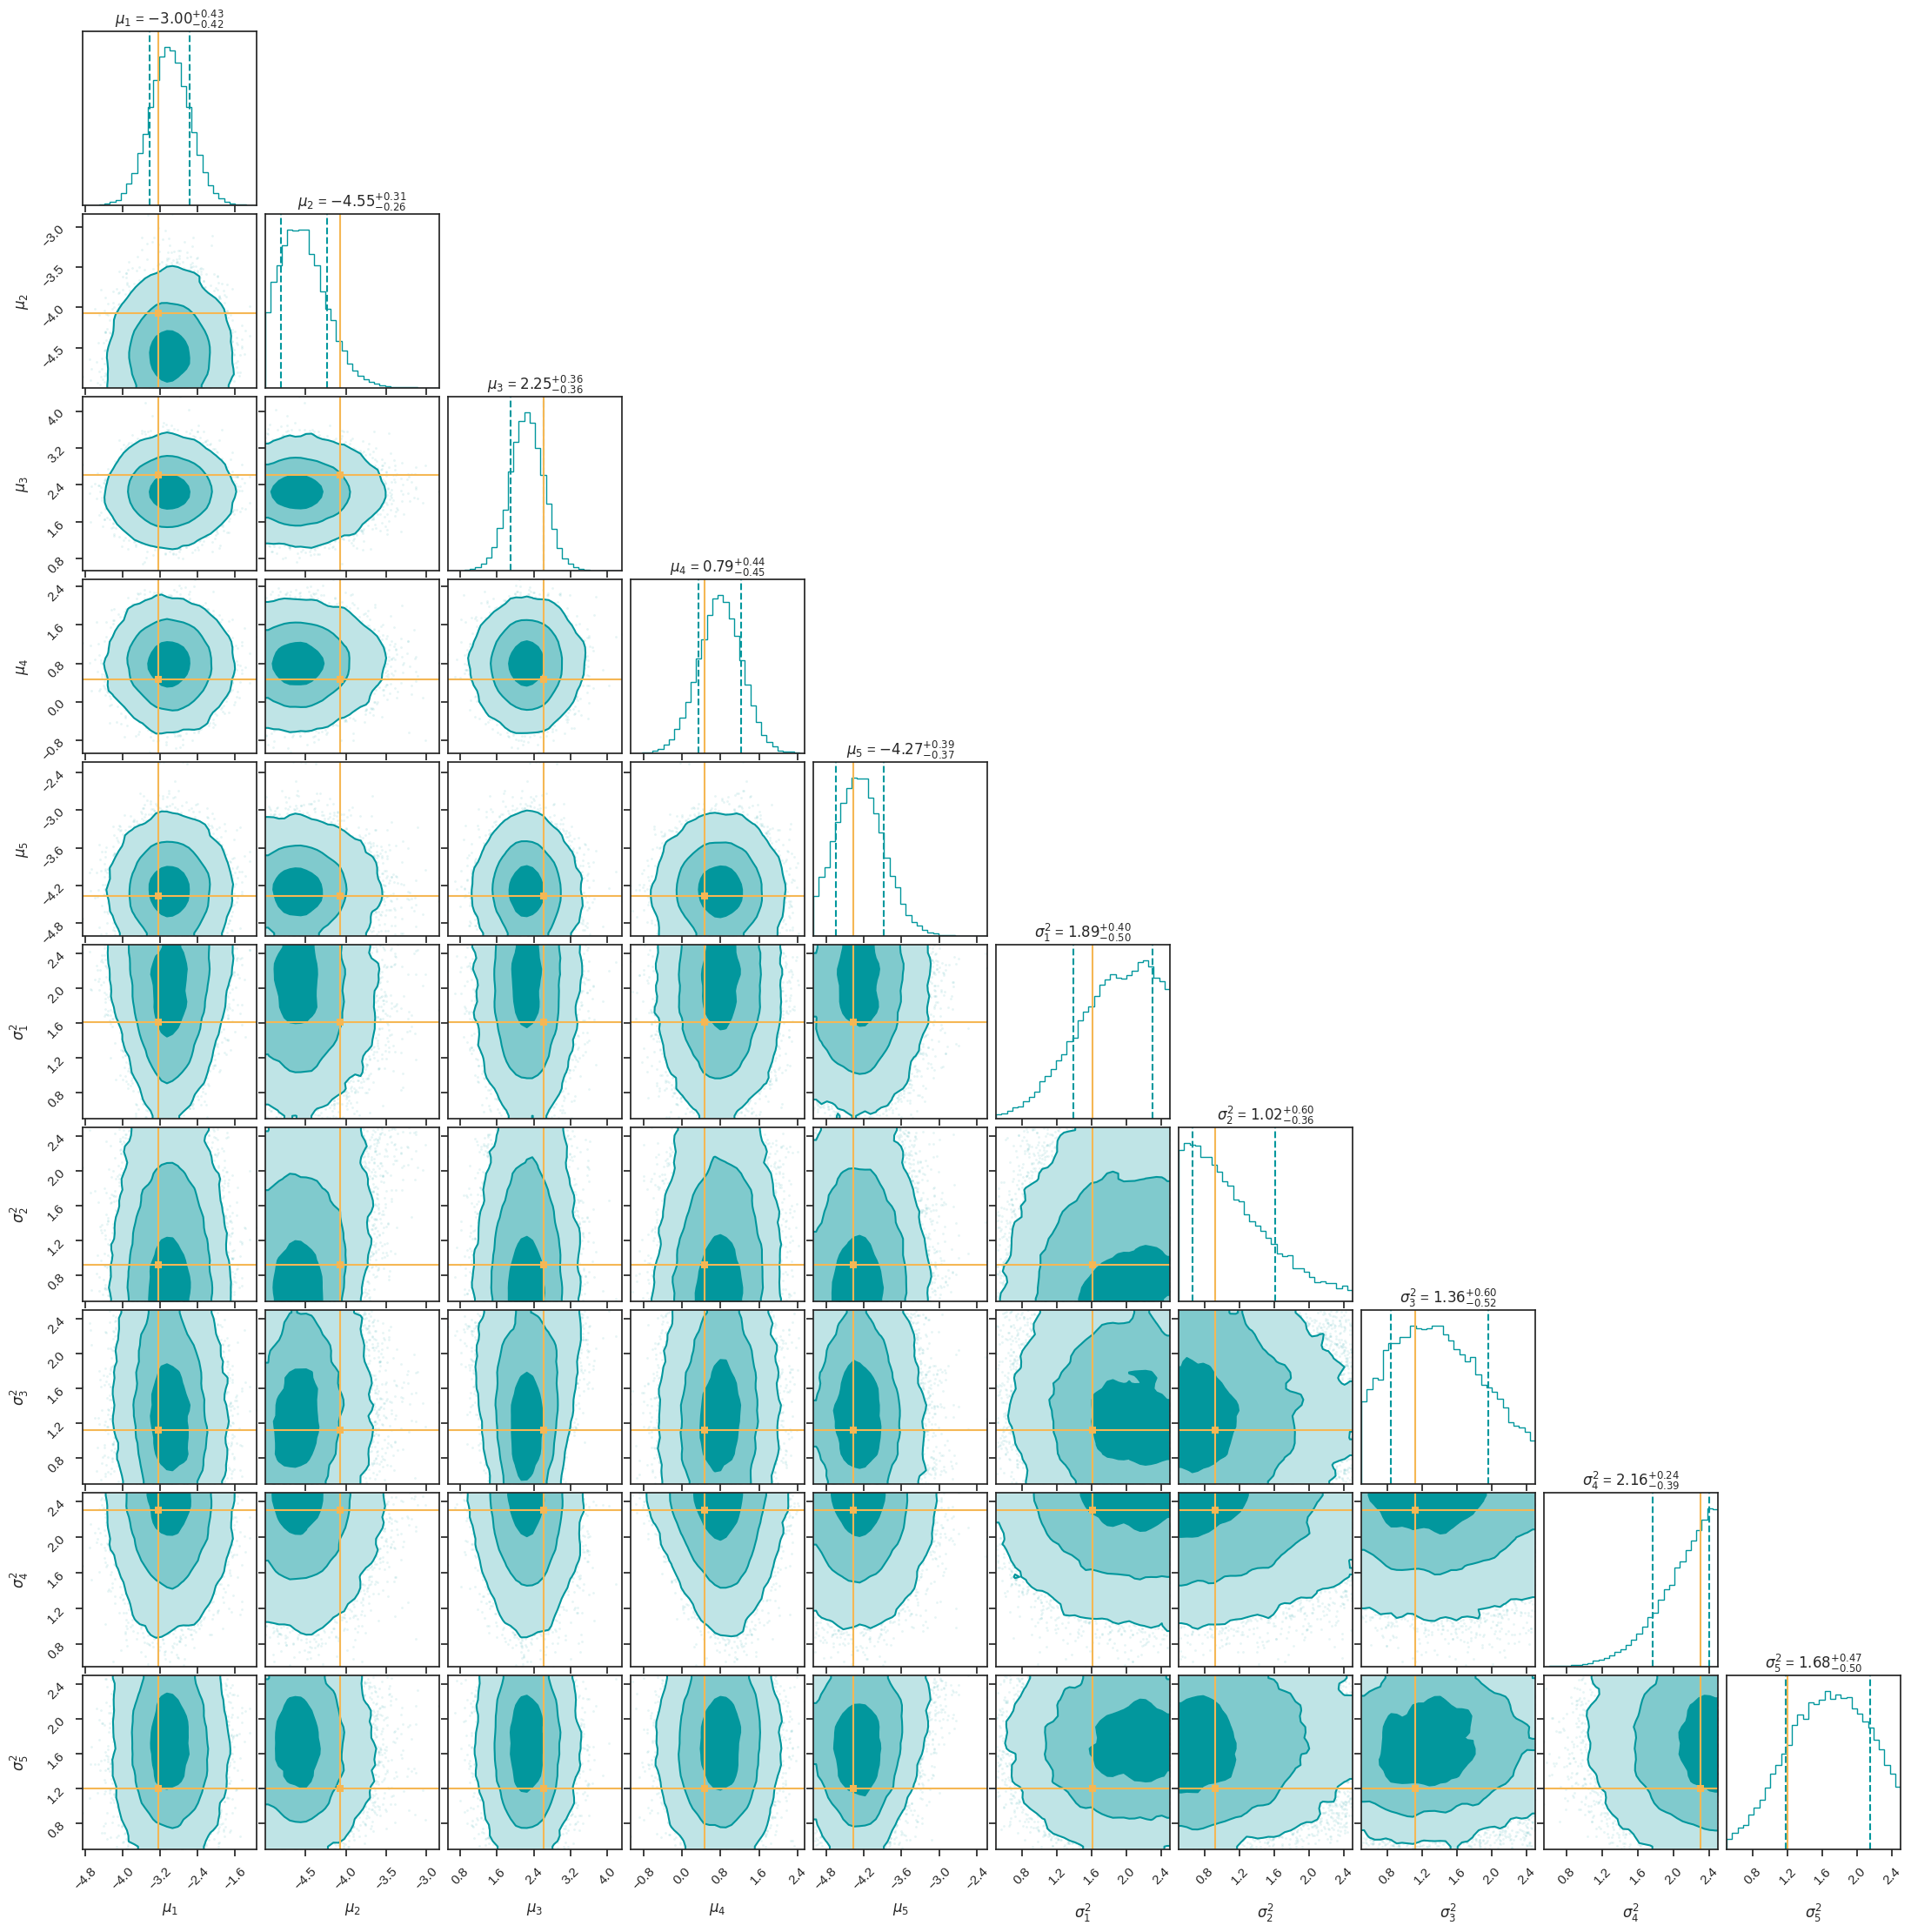

In [39]:
with plt.style.context("seaborn"):
    truths = event_mean.tolist() + event_variance.tolist()
    corner_fig = corner_plot(
        fs_fast.posterior_samples,
        include=names,
        truths=truths,
        labels=[rf"$\mu_{x}$" for x in range(1,6)] + [rf"$\sigma^2_{x}$" for x in range(1,6)],
    )
    corner_fig.savefig(output_fast+'/posterior_w_truth.png')
    plt.show()

We have an answer and it looks reasonable. To see if it's trustworthy we can directly perform the hierarchical inference in this case and see if the results are consistent...

### Analytic Hierarchical Inference (comparison)

In [19]:
#nessai model class
class HierarchicalModel(Model):
    """A simple Gaussian likelihood."""

    def __init__(self, names, bounds, data):
        # Names of parameters to sample
        self.names = names
        # Prior bounds for each parameter
        self.bounds = bounds
        self.data = torch.as_tensor(data).float().to(device)#.reshape(-1,data.shape[-1])
        self.nsamp = data.shape[1] 
        self.nevents = data.shape[0]
        self._vectorised_likelihood = False #bad 

    def unpack_live_point(self, x):
        start = np.array([x[n] for n in self.names]).T
        if start.ndim == 1:
            start = start[None,:]
        return torch.Tensor(start).float().to(device)

    def log_prior(self, x):
        """
        Returns log of prior given a live point assuming uniform
        priors on each parameter.
        """
        # Check if values are in bounds, returns True/False
        # Then take the log to get 0/-inf and make sure the dtype is float
        log_p = np.log(self.in_bounds(x), dtype="float").astype(np.float32)
        # Iterate through each parameter (x and y)
        # since the live points are a structured array we can
        # get each value using just the name
        for n in self.names:
            log_p -= np.log(self.bounds[n][1] - self.bounds[n][0])
        return log_p

    def log_likelihood(self, x):
        try:
            if len(x[self.names[0]]) > 1:
                raise NotImplementedError
        except TypeError:
            pass
        conditional = self.unpack_live_point(x)
        log_prob = 0
        for event_data in self.data:
            with torch.no_grad():
                diff = (event_data - conditional[:,:5])
                detcov = torch.prod(conditional[:,5:],dim=-1)
                probs = -0.5*(diff**2 * conditional[:,5:]**-1).sum(axis=-1) - 0.5*torch.log(detcov) - 5/2 * np.log(2*np.pi)
                log_prob += (torch.logsumexp(probs,dim=-1).cpu().numpy() - np.log(self.nsamp))
        return log_prob

In [20]:
model2 = HierarchicalModel(names, bounds, data=event_samples)
output2 = './outdir_norm_hierarchical'
setup_logger(output=output2, log_level='WARNING')
fs2 = FlowSampler(model2, output=output2, resume=False, seed=1729, nlive=5000)
fs2.run()

01-30 16:29 nessai.model WARNING : Multiprocessing pool has already been configured.
01-30 16:29 nessai.samplers.nestedsampler WARNING : Proposal will only train when empty
Drawing live points: 100%|██████████| 5000/5000 [00:19<00:00, 255.92it/s]
01-30 16:29 nessai.samplers.nestedsampler CRITICAL: Starting nested sampling loop
01-30 16:30 nessai.samplers.nestedsampler WARNING : it:  5000: Rolling KS test: D=0.01, p-value=0.3654
01-30 16:30 nessai.samplers.nestedsampler WARNING : it:  5000: n eval: 15000 H: 5.16 dZ: 269.147 logZ: -358.940 +/- 0.032 logLmax: -88.79
01-30 16:31 nessai.samplers.nestedsampler WARNING : it: 10000: Rolling KS test: D=0.0032, p-value=0.9007
01-30 16:31 nessai.samplers.nestedsampler WARNING : it: 10000: n eval: 40000 H: 5.38 dZ: 150.803 logZ: -241.596 +/- 0.033 logLmax: -88.79
01-30 16:31 nessai.samplers.nestedsampler WARNING : Switching to FlowProposal
01-30 16:32 nessai.samplers.nestedsampler WARNING : it: 15000: Rolling KS test: D=0.0108, p-value=0.3093
01-3

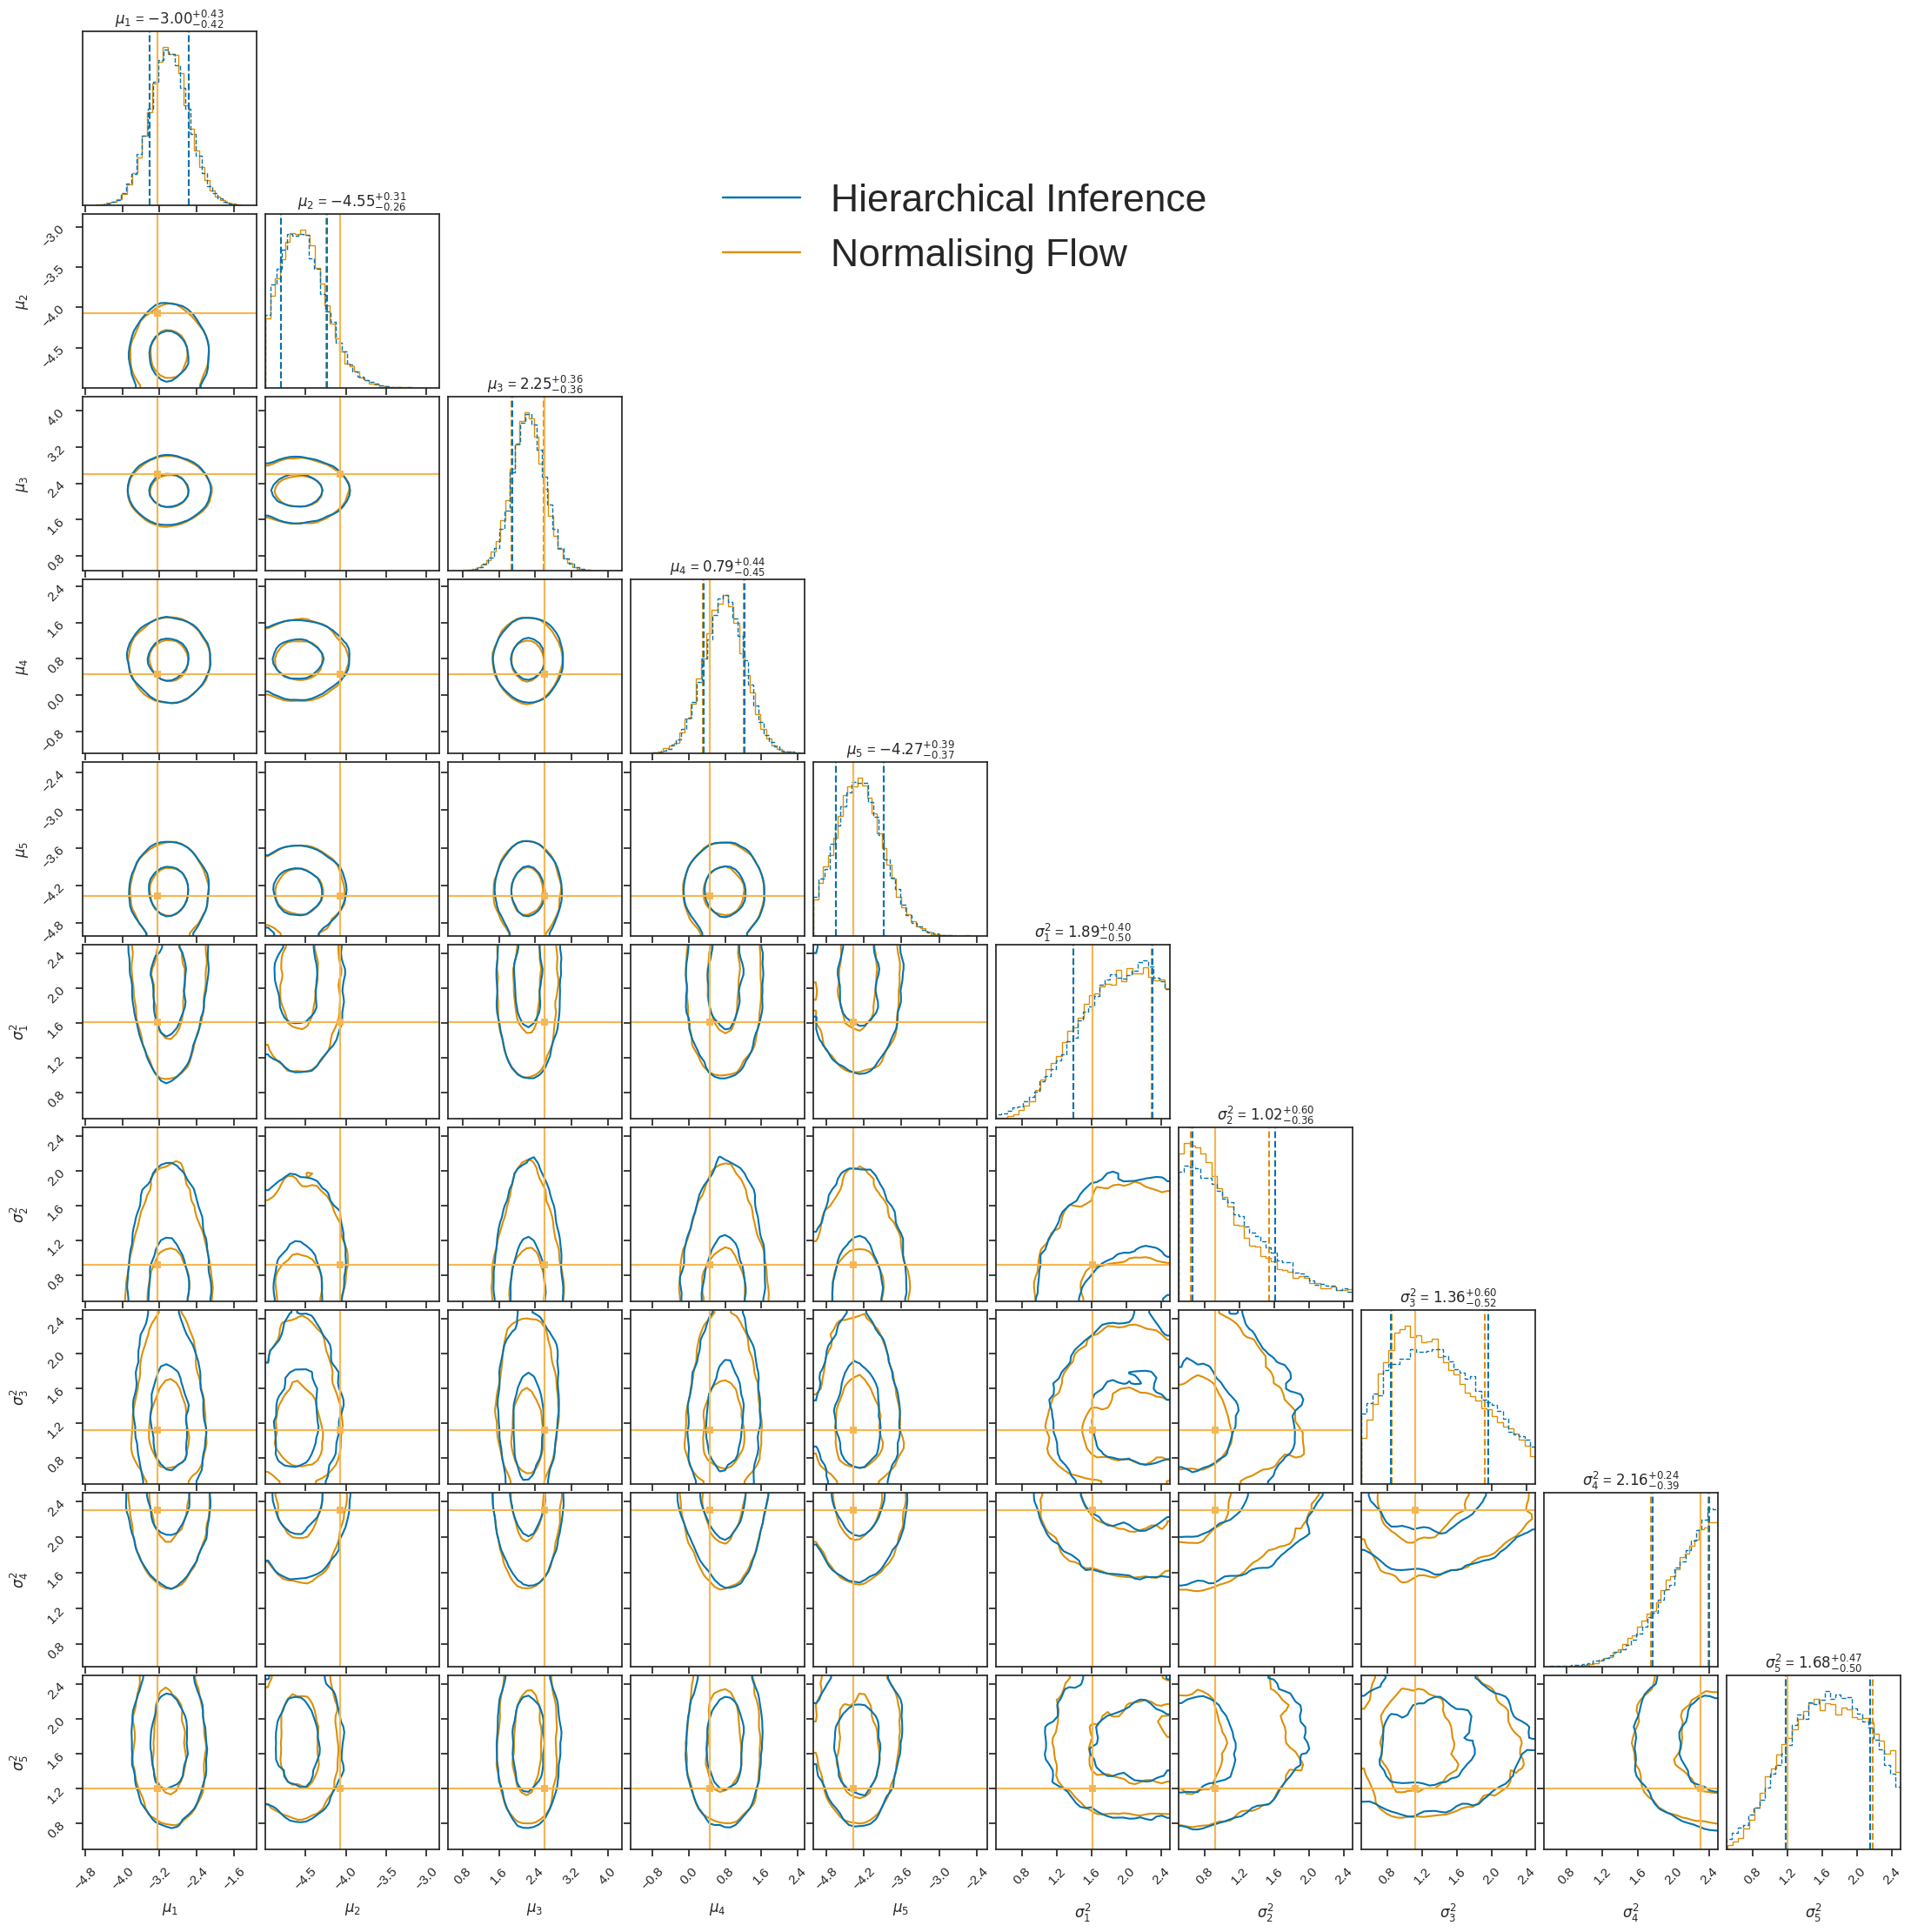

In [40]:
with plt.style.context("seaborn"):
    pal = sns.color_palette(palette="colorblind").as_hex()

    truths = event_mean.tolist() + event_variance.tolist()
    corner_fig = corner_plot(
        fs2.posterior_samples,
        color=pal[1],
        include=names,
        truths=truths,
        labels=[rf"$\mu_{x}$" for x in range(1,6)] + [rf"$\sigma^2_{x}$" for x in range(1,6)],
        hist_kwargs=dict(density=True,color=pal[1]),
        plot_density=False,
        plot_datapoints=False,
        fill_contours=False,
        levels = (1 - np.exp(-0.5), 1-np.exp(-2))
    )

    corner_fig2 = corner_plot(
        fs_fast.posterior_samples,
        color=pal[0],
        include=names,
        truths=truths,
        labels=[rf"$\mu_{x}$" for x in range(1,6)] + [rf"$\sigma^2_{x}$" for x in range(1,6)],
        fig = corner_fig,
        hist_kwargs=dict(density=True,color=pal[0]),
        plot_density=False,
        plot_datapoints=False,
        fill_contours=False,
        levels = (1 - np.exp(-0.5), 1-np.exp(-2))
    )

    import matplotlib.lines as mlines
    blue = mlines.Line2D([],[], color=pal[0], label='Hierarchical Inference')
    orange = mlines.Line2D([],[], color=pal[1], label='Normalising Flow')
    corner_fig2.legend(handles=[blue, orange], loc=(0.37,0.85),fontsize=32, frameon=False)
    corner_fig2.savefig('joint_posterior_w_truth.png')
    plt.show()